# Truncated Distribution Generator

Generate samples from common distributions truncated with lower and upper bounds

[Overleaf paper](https://www.overleaf.com/6325975793zxxhznfsvcgc)

[PyRo](https://pyro.ai/)

VI with 
- Mean Field
- Stein Method

Generate TD for 
- Gaussian 
- Student (T)

In [1]:
%%capture
!pip install qmcpy --quiet
from qmcpy import *
from numpy import *
from numpy.linalg import inv
from scipy import stats
from matplotlib import pyplot
# plot fonts sizes
pyplot.rc('font', size=16)
pyplot.rc('axes', titlesize=16, labelsize=16)
pyplot.rc('xtick', labelsize=16)
pyplot.rc('ytick', labelsize=16)
pyplot.rc('legend', fontsize=16)
pyplot.rc('figure', titlesize=16)

In [2]:
def scat_plot(x,ax,xlim,ylim,s,color,title,pltbds=False,lb=None,ub=None):
    ax.scatter(x[:,0],x[:,1],s=s,color=color)
    ax.set_xlim(xlim);ax.set_xticks(xlim);ax.set_xlabel('$x_{i,1}$')
    ax.set_ylim(ylim);ax.set_yticks(ylim);ax.set_ylabel('$x_{i,2}$')
    ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
    ax.set_title(title)
    if pltbds:
        ax.axhline(y=lb[1], color='k', linestyle='--')
        ax.axhline(y=ub[1], color='k', linestyle='--')
        ax.axvline(x=lb[0], color='k', linestyle='--')
        ax.axvline(x=ub[0], color='k', linestyle='--')

In [3]:
def trunc_gen(x_stdu, lb, ub, distrib, independent=True, **params):
    """
    Transform samples mimicking a standard uniform to mimic a truncated distribution
    
    Args:
        x_stdu (numpy.ndarray): n samples x d dimensional array of samples
        lb (numpy.ndarray): length d lower bound vector
        ub (numpy.ndarray): length d upper bound vector
        distrib (scipy.stats module): a distribution from scipy.stats (i.e.norm,t) 
            that has `cdf` and `ppf` (inverse cdf) functions
        independent (bool): sample dimensions are independent? 
        **params (dict): keyword arguments (parameters) to pass to into `distrib.cdf` and `distrib.ppf`
            
    Return:
        numpy.ndarray: n samples by d dimension array of samples mimicking the truncated distribution
    """
    cdf = distrib.cdf
    invcdf = distrib.ppf
    if independent:
        x_trunc = zeros(x_stdu.shape,dtype=double)
        for j in range(x_trunc.shape[1]):
            params_j = {param:val[j] for param,val in params.items()}
            cdflb = cdf(lb[j],**params_j)
            cdfub = cdf(ub[j],**params_j)
            x_trunc[:,j] = invcdf((cdfub-cdflb)*x_stdu[:,j]+cdflb,**params_j)
        return x_trunc
    else:
        msg = '''
        `trunc_gen` currenly only supports generating samples from 
        distributions with independent dimensions.
        '''
        raise Exception(msg)
        return -1

In [4]:
d = 2
n = 2**8

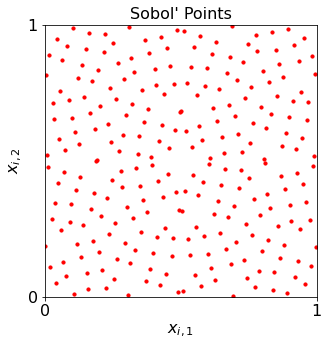

In [5]:
s = Sobol(d,seed=7)
u = s.gen_samples(n)
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(5,5))
scat_plot(u,ax,[0,1],[0,1],s=10,color='r',title="Sobol' Points")

### Generating from Guassian and Student with $\mu=0$ and $\Sigma=1$

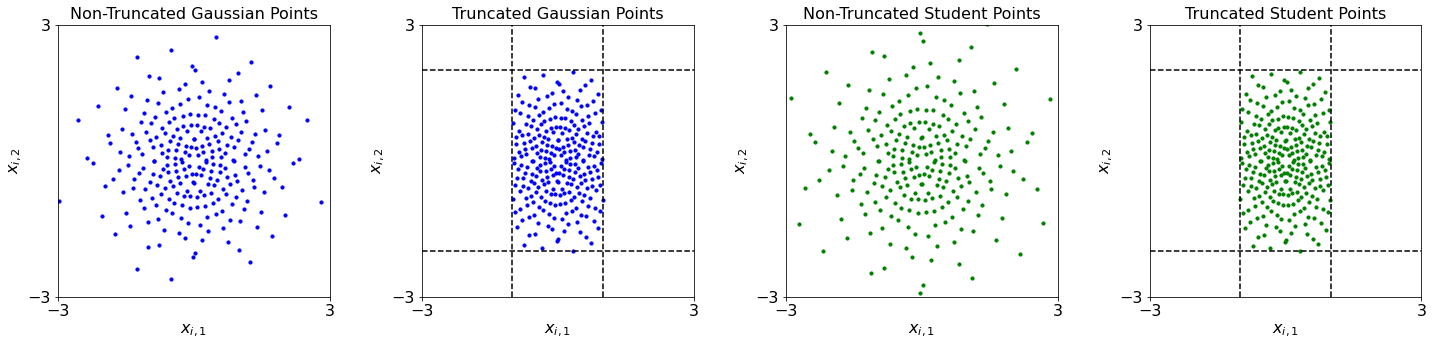

In [6]:
# parameters
trunc_lb = array([-1,-2])
trunc_ub = array([1,2])
# points
g = trunc_gen(u,tile(-inf,d),tile(inf,d),stats.norm)
gt = trunc_gen(u,trunc_lb,trunc_ub,stats.norm)
t = trunc_gen(u,tile(-inf,d),tile(inf,d),stats.t,df=tile(5,d))
tt = trunc_gen(u,trunc_lb,trunc_ub,stats.t,df=tile(5,d))
# plots
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(25,5))
scat_plot(g,ax[0],[-3,3],[-3,3],s=10,color='b',title="Non-Truncated Gaussian Points")
scat_plot(gt,ax[1],[-3,3],[-3,3],s=10,color='b',title="Truncated Gaussian Points",pltbds=True,lb=trunc_lb,ub=trunc_ub)
scat_plot(t,ax[2],[-3,3],[-3,3],s=10,color='g',title="Non-Truncated Student Points")
scat_plot(tt,ax[3],[-3,3],[-3,3],s=10,color='g',title="Truncated Student Points",pltbds=True,lb=trunc_lb,ub=trunc_ub)

### Generating from Gaussian and Student with $\mu=[1,2]$ and $\Sigma=\text{Diag}([1,16])$

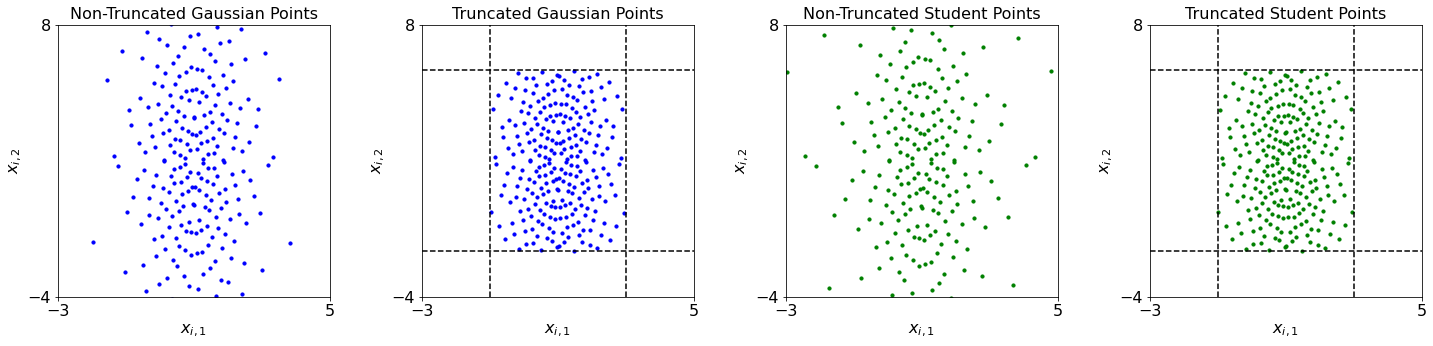

In [7]:
# parameters
mu = array([1,2])
Sigma = array([1,16])
trunc_lb = [-1,-2]
trunc_ub = [3,6]
# points
g = trunc_gen(u,tile(-inf,d),tile(inf,d),stats.norm,loc=mu,scale=sqrt(Sigma))
gt = trunc_gen(u,trunc_lb,trunc_ub,stats.norm,loc=mu,scale=sqrt(Sigma))
t = trunc_gen(u,tile(-inf,d),tile(inf,d),stats.t,df=tile(5,d),loc=mu,scale=sqrt(Sigma))
tt = trunc_gen(u,trunc_lb,trunc_ub,stats.t,df=tile(5,d),loc=mu,scale=sqrt(Sigma))
# plots
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(25,5))
scat_plot(g,ax[0],[-3,5],[-4,8],s=10,color='b',title="Non-Truncated Gaussian Points")
scat_plot(gt,ax[1],[-3,5],[-4,8],s=10,color='b',title="Truncated Gaussian Points",pltbds=True,lb=trunc_lb,ub=trunc_ub)
scat_plot(t,ax[2],[-3,5],[-4,8],s=10,color='g',title="Non-Truncated Student Points")
scat_plot(tt,ax[3],[-3,5],[-4,8],s=10,color='g',title="Truncated Student Points",pltbds=True,lb=trunc_lb,ub=trunc_ub)

# Stein Method

$\newcommand{\bs}[1]{\boldsymbol{#1}}$
Based on the paper: [Stein Variational Gradient Descent: A General Purpose Bayesian Inference Algorithm](https://arxiv.org/abs/1608.04471). 

Algorithm 1 of the above paper wants us to compute:$$\hat{\phi}^*(\bs{z})=\frac{1}{n}\sum_{i=1}^n\left[k(\bs{x}_i,\bs{z})\nabla_{\bs{x}_i}\log(p(\bs{x}_i))+\nabla_{\bs{x}_i} k(\bs{x}_i,\bs{z})\right]$$

Assume we are using the [RBF kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)
$$k(\bs{x},\bs{z})=\exp(-\lVert \bs{x}-\bs{z} \rVert^2 /h)$$
with gradient 
$$\nabla_{x'}k(\bs{x},\bs{z})=\frac{2}{h}k(\bs{x},\bs{z})\sum_{i=1}^n (\bs{z}-\bs{x})$$

Also assume we want to generate from a truncated multi-variate Gaussian. Letting C be a normalizaiton constant, $\bs{L},\bs{U}$ lower and upper bounds respectively, and $\chi$ the indicator function, then the truncated density is  
$$p(\bs{x}|\bs{\mu},\bs{\Sigma},\bs{L},\bs{U})=C(2\pi)^{-d/2}\det(\bs{\Sigma})^{-1/2}\exp(-(\bs{x}-\bs{\mu})^T\bs{\Sigma}^{-1}(\bs{x}-\bs{\mu})/2)\chi_{(\bs{L},\bs{U})}(\bs{x}),$$
the $\log$ density is
$$\log(p(\bs{x}|\bs{\mu},\bs{\Sigma},\bs{L},\bs{U}))=\left(log(C)-\frac{d}{2}\log(2\pi)-\frac{1}{2}\log(\det(\bs{\Sigma})) - \frac{1}{2}(\bs{x}-\bs{\mu})^T\bs{\Sigma}^{-1}(\bs{x}-\bs{\mu})\right)\chi_{(\bs{L},\bs{U})},$$
and the gradient of the log density is 
$$\nabla_{\bs{x_j}} \log(p(\bs{x}|\bs{\mu},\bs{\Sigma},\bs{L},\bs{U})) = \left(\bs{\mu}^T\bs{\Sigma}^{-1} -\bs{x}^T\bs{\Sigma}^{-1}\right)\chi_{(\bs{L},\bs{U})}.$$

We can then update the particles such that
$$x \leftarrow x+\epsilon\hat{\phi}^*(\bs{x})$$

In [74]:
class GTGS(object):
    """ Gaussian Truncated Distribution Generator by Stein Method"""
    def __init__(self, mu, Sigma, L, U, epsilon, x_init):
        self.mu = mu.reshape((-1,1))
        self.Sigma = Sigma
        self.L = L.flatten()
        self.U = U.flatten()
        self.epsilon = epsilon
        self.x = x_init
        self.k_rbf = lambda x, z, h=.5: exp(((x-z)**2).sum(1)/h)
        self.dk_rbf = lambda x, z, h=.5: 2*self.k_rbf(x,z,h)*(z-x).sum(1)/h
        self.dlogpt = lambda x: (mu.T@inv(Sigma) - x@inv(Sigma)) *  ((x>self.L).all(1)&(x<self.U).all(1))[:,None]
        self.phiHatStar = lambda z: (self.k_rbf(self.x,z)[:,None]*self.dlogpt(self.x)+self.dk_rbf(self.x,z)[:,None]).mean(0)
    '''
    def phiHatStar(self,z):
        t1 = self.k_rbf(self.x,z)
        t2 = self.dlogpt(self.x)
        t3 = self.dk_rbf(self.x,z)
        print(t1.shape,t2.shape,t3.shape,(t1[:,None]*t2).shape)
        return (t1*t2+t3).mean(0)
    def dlogpt(self, x):
            t1 = mu.T@inv(Sigma)
            t2 = x@inv(Sigma)
            t3 = ((x>self.L).all(1)*(x<self.U).all(1))[:,None]
            print(t1.shape,t2.shape,(t1-t2).shape,t3.shape)
            t = (t1-t2)*t3
            return t
    '''
    def step(self):
        self.x += self.epsilon*self.phiHatStar(self.x)
        return self.x
    def walk(self,steps):
        for i in range(steps):
            self.step()
        return self.x

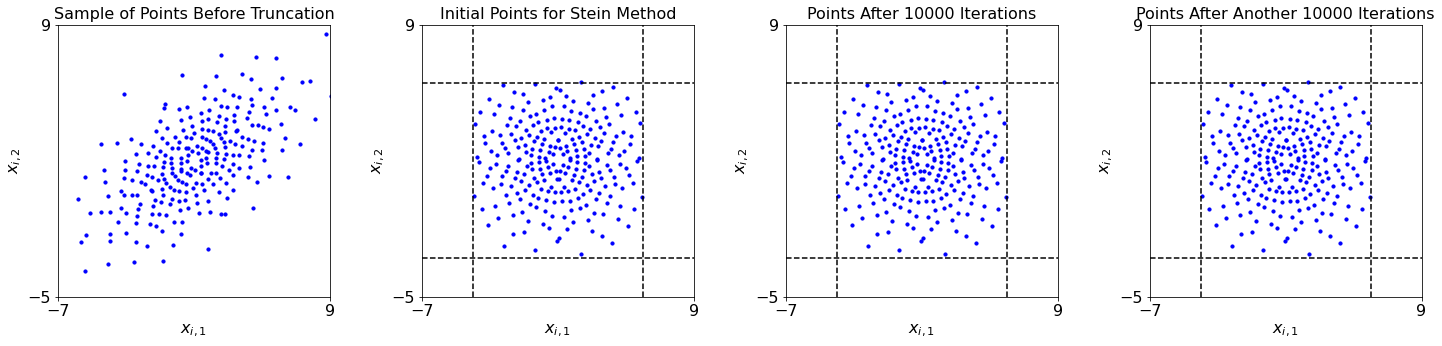

In [79]:
# parameters
mu = array([1,2],dtype=float)
Sigma = array([[9,4],[4,5]],dtype=float)
L = array([-4,-3],dtype=float)
U = array([6,6],dtype=float)
epsilon = 1
walk1 = 10000
walk2 = 10000
# points
#    1
evals,evecs = linalg.eigh(Sigma)
order = argsort(-evals)
A = dot(evecs[:,order],diag(sqrt(evals[order]))).T
x = stats.norm.ppf(u)@A+mu
#    2
x_init = trunc_gen(u,L,U,stats.norm,loc=mu,scale=sqrt(Sigma.diagonal()))
#    3
gtgs = GTGS(mu,Sigma,L,U,epsilon,x_init)
xw1 = gtgs.walk(walk1)
#    4
xw2 = gtgs.walk(walk2)
# plots
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(25,5))
scat_plot(x,ax[0],[-7,9],[-5,9],s=10,color='b',title="Sample of Points Before Truncation")
scat_plot(x_init,ax[1],[-7,9],[-5,9],s=10,color='b',title="Initial Points for Stein Method",pltbds=True,lb=L,ub=U)
scat_plot(xw1,ax[2],[-7,9],[-5,9],s=10,color='b',title="Points After %d Iterations"%walk2,pltbds=True,lb=L,ub=U)
scat_plot(xw2,ax[3],[-7,9],[-5,9],s=10,color='b',title="Points After Another %d Iterations"%walk2,pltbds=True,lb=L,ub=U)